# Coronavirus Cases in Finland

##### __Bernardo Di Chiara__

_Last plotted day: see the end of the file_

## Table of Contents

[1. Executive Summary](#1.)<br>
[2. Setup](#2.)<br>
[3. Defining the Needed Functions](#3.)<br>
<font color='white'>....</font>[3.1. Dataframes and lists handling](#3.1.)<br>
<font color='white'>....</font>[3.2. Scatter and line plots](#3.2.)<br>
<font color='white'>....</font>[3.3. Project-specific functions](#3.3.)<br>
[4. Dumping the Data](#4.)<br>
[5. Data Analysis](#5.)<br>
<font color='white'>....</font>[5.1. Summary](#5.1.)<br>
<font color='white'>....</font>[5.2. Preliminary Data Analysis](#5.2.)<br>
<font color='white'>....</font>[5.3. Data Cleansing](#5.3.)<br>
<font color='white'>....</font>[5.4. Data Preparation](#5.4.)<br>
<font color='white'>............</font>[5.4.1. New datasets with no NaN, no GPS coordinates / list of days](#5.4.1.)<br>
<font color='white'>............</font>[5.4.2. Finnish Data](#5.4.2.)<br>
<font color='white'>............</font>[5.4.3. World data](#5.4.3.)<br>
<font color='white'>............</font>[5.4.4. Data from other Scandinavian Countries](#5.4.4.)<br>
<font color='white'>............</font>[5.4.5. Data from Italy](#5.4.5.)<br>
<font color='white'>............</font>[5.4.6. Data from China](#5.4.6.)<br>
<font color='white'>....</font>[5.5. Summary of the created datasets](#5.5.)<br>
[6. Data Visualization](#6.)<br>
<font color='white'>....</font>[6.1. Finnish Internal Situation](#6.1.)<br>
<font color='white'>....</font>[6.2. Comparison with Other Scandinavian Countries](#6.2.)<br>
<font color='white'>....</font>[6.3. Comparison with Italy and China](#6.3.)<br>
[7. Statistics](#7.)<br>
<font color='white'>....</font>[7.1. World view](#7.1.)<br>
<font color='white'>....</font>[7.2. Finland](#7.2.)<br>
[8. Conclusions](#8.)<br>

## 1. Executive Summary <a name="1."></a>

This notebook contains visualizations related to the spread of Coronavirus in Finland.

The data is taken from the [Johns Hokpins University](https://github.com/CSSEGISandData/COVID-19) (JHU) /1/.

There are a lot of pages related to this topic in the Web but currently there is no free site that shows plots of the daily cases in Finland with a reasonable delay. Also, it might be beneficial to compare Finnish curves with curves from other Countries.

Having updated charts is very useful both for authorities and population in order to make fact-based decisions that help to contain the cases and minimize the casualties. Comparing to what is happening / has happened to other Countries can help in decision making.

A line plot containing confirmed cases each day as well as recovered cases and deceased cases in Finland has been produced.

A second line plot containing the new confirmed daily cases in Finland, which shows the speed at which the virus is spreading, has been added.

It might be useful to compare Finnish curves to those of neighboring Countries since in addition to the geographical proximity those Countries, have certain similarities in culture, behavior patterns and may be genetics.

Finnish curves have been compared also to the curves of the two Countries which have had the most critical situation so far: China and Italy.

Finally, a plot with worldwide data has been produced.

<sub>/1/<br>
https://github.com/CSSEGISandData/COVID-19</sub>

**If you are not interested in the code, go to section 6 and focus on the plots and their description.**

**DISCLAIMER:**
    
- The code has not been peer-reviewed. If someone is wishing to do it, please contact the author.
- The data related to the last day might be incomplete.

## 2. Setup <a name="2."></a>

In [1]:
# Importing the needed packages
import os
import datetime as dt
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying all the dafaframe columns
pd.set_option('display.max_columns', None)

## 3. Defining the Needed Functions <a name="3."></a>

### 3.1. Dataframe handling<a name="3.1."></a>

In [2]:
def df_basic_data(dfname):
    '''
    This function prints basic information about a given dataframe.
    The function needs as input parameters the dataframe name.
    '''

    import pandas as pd

    # Fetching the dataframe name
    name = [x for x in globals() if globals()[x] is dfname][0]
    print("Dataframe name:", name, "\n")
    print("Dataframe length:", len(dfname), "\n")
    print("Number of columns:", len(dfname.columns), "\n")
    # Columns data types
    data_types = dfname.dtypes
    # Distint values
    distint_values = dfname.apply(pd.Series.nunique)
    # Amount of null values
    null_values = dfname.isnull().sum()
    print("Dataframe's columns names, column data types, amount of distint "
          "(non null) values\n"
          "and amount of null values for each column:")
    df_index = ['Data_Type',
                'Amount_of_Distint_Values',
                'Amount_of_Null_Values']
    col_types_dist_null = pd.DataFrame([data_types,
                                        distint_values,
                                        null_values],
                                       index=df_index)
    return col_types_dist_null.transpose()

In [3]:
def calc_increments(listname):
    '''
    This function:
    takes a list,
    calculates the delta between each element and its predecessor,
    returns the result in a new list having the same lenght as the original list
    '''

    # Initializing an empty list of floats to contain the increments
    increments = []
    # Adding zero to the first element
    increments.append(0.0)
    # Looping through all the occurrencies except the first one
    for i in list(range(1, len(listname))):
        # Calculating the increment
        delta = listname[i]-listname[i-1]
        # Adding the result to the list
        increments.append(delta)
    # Returning the result
    return increments

### 3.2. Scatter and line plots<a name="3.2."></a>

In [4]:
def cust_line_plot(*parameters,
                   figsize_w=8, figsize_h=6,
                   title=None, title_fs=16, title_offset=20,
                   rem_borders=False,
                   x_label=None, xlabel_fs=12,
                   xvalues_fs=6, rot=0,
                   y_label=None, ylabel_fs=12,
                   legend=False):
    """
    This function plots a scatterplot for the provided data
    and customizes the way the chart looks by using the value of
    the provided parameters.

    Keyword arguments:
    parameters       -- A tuple of 5 elements containing:
                        a list with the x values,
                        a list with the y values,
                        a string containing the selected marker,
                        an integer (from 0 to 9) selecting the seaborn-deep
                        color,
                        a string containing the text for the legend
                        (mandatory)
    x                -- A list Series containing the x values (mandatory)
    figsize_w        -- The width of the plot area
    figsize_w        -- The height of the plot area
    title            -- A string containing the title of the chart
    title_fs         -- The title font size
    title_offset     -- Distance between the title and the top of the chart
    rem_borders      -- If True the top and right borders are removed
                        (default: False)
    x_label          -- Label for the x-axis (string)
    xlabel_fs        -- x axis labels' font size
    xvalues_fs       -- The tick values font size
    rot              -- The rotation angle of the tick values
    y_label          -- Label for the y-axis (string)
    ylabel_fs        -- y axis labels' font size
    legend           -- A boolean variable that tells if to plot a legend
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Creating a new figure
    plt.figure(figsize=(figsize_w, figsize_h))
    # Defining the used style
    color_list = sns.color_palette(palette='deep')
    # Adding a title (with some distance to the top of the plot)
    plt.title(title, fontsize=title_fs, pad=title_offset)
    # Removing the top and right borders if so defined
    if rem_borders is True:
        sns.despine(top=True, right=True, left=False, bottom=False)

    # Initializing an empy list to contain the legend text
    leg_text_l = []
    for param in parameters:
        # Extracting the values given in parameters
        x = param[0]
        y = param[1]
        mark = param[2]
        col_numb = param[3]
        leg_text = param[4]
        # Appending the string to the list
        leg_text_l.append(leg_text)
        # Creating the scatter plots
        plot = plt.plot(x, y, marker=mark, color=color_list[col_numb])

    # If a label for the x axis is provided, showing it on the x axis
    if x_label:
        plt.xlabel(x_label, fontsize=xlabel_fs)
    plt.xticks(fontsize=xvalues_fs, rotation=rot)
    # If a label for the y axis is provided, showing it on the y axis
    if y_label:
        plt.ylabel(y_label, fontsize=ylabel_fs)

    # Adding a legend
    if legend:
        plt.legend(labels=leg_text_l)

    # Showing the plot without additional text
    plt.show()

### 3.3. Project-specific functions<a name="3.3."></a>

In [5]:
def find_last_day():
    '''
    This function reads in a certain directory to find the latest CSV file
    and returns the date of the last file in a string in the format mm-dd-yyyy
    '''

    # Getting the list of files in the daily reports folder
    for roots, dirs, files in os.walk('JHU_COVID-19/COVID-19/'
                                      'csse_covid_19_data/'
                                      'csse_covid_19_daily_reports'):
        file_list = files  # list of strings
        # Initializing a new list
        dates = []
        # Iterating through the original list
        for i in list(range(len(file_list))):
            file = file_list[i]
            # If is it a csv file ...
            if re.search("\S+[csv]", file):
                # Extracting the date into a list of string
                date = re.findall("[0-9]+[-][0-9]+[-][0-9]+", file)
                # Converting the format from string to date
                dt_date = dt.datetime.strptime(date[0], "%m-%d-%Y")
                # Appending the date to a list of dates (the new list)
                dates.append(dt_date)
    # Sorting the dates and taking the last one
    dates.sort(reverse=True)
    latest = dates[0]  # datetime
    # Converting the latest date to a string
    last_day = latest.strftime("%m-%d-%Y")

    return last_day

In [6]:
def extract_country(country, days):
    '''
    This function allows selecting data related to a specific Country
    from the datasets produced by JHU.
    It takes as an input a string containing the Country name and 
    an integer containing how many days to skip.
    It returns a tuple of 3 lists containing data related to confirmed,
    recovered and deceased cases startinng from January 28th.
    '''

    # Extracting confirmed cases
    confirm = world_confirmed[world_confirmed['Country/Region'] == country]
    # Extracting the columns containing the data for each day
    # starting from the first day of interest for Finland (January 28th)
    confirm = confirm.iloc[:, 4+days:]
    # Copying the result into a list
    confirm_l = confirm.values.tolist()[0]

    # Extracting recovered cases
    recov = world_recovered[world_recovered['Country/Region'] == country]
    # Extracting the columns containing the data for each day
    # starting from the first day of interest for Finland (January 28th)
    recov = recov.iloc[:, 4+days:]
    # Copying the result into a list
    recov_l = recov.values.tolist()[0]

    # Extracting deceased cases
    deceas = world_deceased[world_deceased['Country/Region'] == country]
    # Extracting the columns containing the data for each day
    # starting from the first day of interest for Finland (January 28th)
    deceas = deceas.iloc[:, 4+days:]
    # Copying the result into a list
    deceas_l = deceas.values.tolist()[0]

    return confirm_l, recov_l, deceas_l

In [7]:
def extract_non_null(input_list):
    '''
    This function takes as input a list that contains a certain number of
    zero values, omits such values and returns what is left in a new list.
    '''

    # Initializing a list
    no_null = []
    # Looping through all the elements of the list
    for i in list(range(len(input_list))):
        if input_list[i] != 0:
            # Extracting non null values
            no_null.append(input_list[i])

    return no_null

## 4. Dumping the Data <a name="4."></a> 

The source csv files are located in the following directoryies:
- <code>JHU_COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series</code>
- <code>JHU_COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports</code>

Those directory shall be located under the directory containing this notebook.

In [8]:
# Loading the data files into pandas dataframes
# Loading the world time series
world_confirmed = pd.read_csv('JHU_COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
world_recovered = pd.read_csv('JHU_COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
world_deceased = pd.read_csv('JHU_COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')

In [9]:
# Uploading the latest daily report
last_day = find_last_day()  # calling the function last_day
daily_report = pd.read_csv('JHU_COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/' + last_day + '.csv')

**File descriptions**

- <code>time_series_19-covid-Confirmed.csv</code>: confirmed cases for each day for each Country
- <code>time_series_19-covid-Recovered.csv</code>: confirmed cases for each day for each Country
- <code>time_series_19-covid-Deaths.csv</code>: confirmed cases for each day for each Country
- <code>mm-dd-yyyy.csv</code>: last available daily report

## 5. Data Analysis <a name="5."></a>

### 5.1. Summary<a name="5.1."></a>

The 3 time series files have columns for Province/State, Country/Region, Latitude, Longitude and data for each day. The columns related to the day are named in the format m/d/yy.

Each entry represents a different location.

Data about Finland has been extracted from the files produced by Johns Hopikns University.

Data related to days with non-zero confirmed cases has been extracted.

The same has been done for Scandinavian Countries, Italy and China.

Total global figures have been calculated.

The original files have been cleansed by changing the NaN value sin the "Province/State" variable into the string "Not available".

A summary of the cerated datasets is available in section 5.5.

### 5.2. Preliminary Data Analysis<a name="5.2."></a>

In [10]:
# Showing basic dataframe info
df_basic_data(world_confirmed)

Dataframe name: world_confirmed 

Dataframe length: 462 

Number of columns: 61 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,317,143
Country/Region,object,152,0
Lat,float64,453,0
Long,float64,439,0
1/22/20,int64,11,0
...,...,...,...
3/14/20,int64,126,0
3/15/20,int64,131,0
3/16/20,int64,134,0
3/17/20,int64,149,0


In [11]:
# Showing basic dataframe info
df_basic_data(world_recovered)

Dataframe name: world_recovered 

Dataframe length: 462 

Number of columns: 61 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,317,143
Country/Region,object,152,0
Lat,float64,453,0
Long,float64,439,0
1/22/20,int64,2,0
...,...,...,...
3/14/20,int64,56,0
3/15/20,int64,56,0
3/16/20,int64,55,0
3/17/20,int64,57,0


In [12]:
# Showing basic dataframe info
df_basic_data(world_recovered)

Dataframe name: world_recovered 

Dataframe length: 462 

Number of columns: 61 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,317,143
Country/Region,object,152,0
Lat,float64,453,0
Long,float64,439,0
1/22/20,int64,2,0
...,...,...,...
3/14/20,int64,56,0
3/15/20,int64,56,0
3/16/20,int64,55,0
3/17/20,int64,57,0


In [13]:
# Showing basic dataframe info
df_basic_data(daily_report)

Dataframe name: daily_report 

Dataframe length: 284 

Number of columns: 8 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,128,154
Country/Region,object,163,0
Last Update,object,102,0
Confirmed,int64,155,0
Deaths,int64,28,0
Recovered,int64,62,0
Latitude,float64,280,0
Longitude,float64,281,0


In [14]:
# Checking how data looks like
world_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790


In [15]:
# Checking how data looks like
world_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,12,12,12,14,15,15,15,15,17,17,21,21,22,22,22,28,28,28,31,31,31,31,31,31,31,31,33,34,34,35,35,35,35,41,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118,118,118,118,118,144,144,144
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,9,15,15,17,18,18,24,29,34,34,37,37,51,51,53,62,62,62,72,72,78,78,78,78,78,78,78,78,78,96,96,97,105,105,109,114,114
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,3,7,7,7,13,15,15,15,15,15,18,18,18,18,18,18,18,18,22,22,22,22,23,24,24,24,26,26,26,35,42,42,49,60


In [16]:
# Checking how data looks like
world_deceased.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15,16,19,22,22,27,29,29
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


In [17]:
# Checking how data looks like
daily_report.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-18T12:13:09,67800,3122,56927,30.9756,112.2707
1,NaN,Italy,2020-03-18T17:33:05,35713,2978,4025,41.8719,12.5674
2,NaN,Iran,2020-03-18T12:33:02,17361,1135,5389,32.4279,53.6880
3,NaN,Spain,2020-03-18T13:13:13,13910,623,1081,40.4637,-3.7492
4,NaN,Germany,2020-03-18T19:33:02,12327,28,105,51.1657,10.4515


### 5.3. Data Cleansing<a name="5.3."></a>

In [18]:
# Converting null values in strings with value "Not applicable"
world_conf_clean = world_confirmed.fillna("Not applicable")
world_recov_clean = world_recovered.fillna("Not applicable")
world_deceas_clean = world_deceased.fillna("Not applicable")
daily_rep_clean = daily_report.fillna("Not applicable")

### 5.4. Data Preparation<a name="5.4."></a>

#### 5.4.1. New datasets with no NaN, no GPS coordinates / list of days <a name="5.4.1."></a>

In [19]:
# Dropping the GPS coordinates and storing the result in new datasets
world_conf_short = world_conf_clean.drop(['Lat', 'Long'], axis=1)
world_recov_short = world_recov_clean.drop(['Lat', 'Long'], axis=1)
world_deceas_short = world_deceas_clean.drop(['Lat', 'Long'], axis=1)
# Dropping the GPS coordinates and last update info and storing the result in new datasets
daily_rep_short = daily_rep_clean.drop(['Latitude', 'Longitude', 'Last Update'], axis=1)

# Grouping by Province/State and storing the result in new datasets
world_conf_group = world_conf_short.groupby(['Country/Region']).sum()
world_recov_group = world_recov_short.groupby(['Country/Region']).sum()
world_deceas_group = world_deceas_short.groupby(['Country/Region']).sum()
daily_rep_group = daily_rep_short.groupby(['Country/Region']).sum()

In [20]:
# Creating a list of dates

# Extracting only the columns containing the virus cases data for each day
world_conf_data = world_confirmed.iloc[:,4:]
# Extracting the column values (dates) and putting them in a list
days_all = world_conf_data.columns.values.tolist()

# Initializing an empty list
days_tot = []
# Looping through the number of days
for i in list(range(len(days_all))):
    # Extracting day and month and taking just the string value
    new_element=re.findall("[0-9]+[/][0-9]+", days_all[i])[0]
    # Adding the result to the list
    days_tot.append(new_element)
    
days_tot

['1/22',
 '1/23',
 '1/24',
 '1/25',
 '1/26',
 '1/27',
 '1/28',
 '1/29',
 '1/30',
 '1/31',
 '2/1',
 '2/2',
 '2/3',
 '2/4',
 '2/5',
 '2/6',
 '2/7',
 '2/8',
 '2/9',
 '2/10',
 '2/11',
 '2/12',
 '2/13',
 '2/14',
 '2/15',
 '2/16',
 '2/17',
 '2/18',
 '2/19',
 '2/20',
 '2/21',
 '2/22',
 '2/23',
 '2/24',
 '2/25',
 '2/26',
 '2/27',
 '2/28',
 '2/29',
 '3/1',
 '3/2',
 '3/3',
 '3/4',
 '3/5',
 '3/6',
 '3/7',
 '3/8',
 '3/9',
 '3/10',
 '3/11',
 '3/12',
 '3/13',
 '3/14',
 '3/15',
 '3/16',
 '3/17',
 '3/18']

#### 5.4.2. Finnish data <a name="5.4.2."></a>

In [21]:
# Calling the function extract_country to extract data related to Finland
# (skipping the first 6 days since they contain no confirmed cases)
Finland_6 = extract_country("Finland", 6)
# Extracting the confirmed cases
finland_conf_6 = Finland_6[0]
# Extracting the recivered cases
finland_recov_6 = Finland_6[1]
# Extracting the decased cases
finland_deceas_6 = Finland_6[2]

# Creating a list of days to use for Finnish charts
# (skipping the first 6 days)
days_fin = days_tot[6:]

In [22]:
print("first day:", days_fin[0])
print("number of days:", len(days_fin))

first day: 1/28
number of days: 51


In [23]:
# Visualizing the complete series
finland_conf_6

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 6,
 6,
 6,
 6,
 12,
 15,
 15,
 23,
 30,
 40,
 59,
 59,
 155,
 225,
 244,
 277,
 321,
 336]

In [24]:
# Visualizing the complete series
finland_recov_6

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 10,
 10,
 10,
 10]

In [25]:
# Visualizing the complete series
finland_deceas_6

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [26]:
# Creating a list of same lenght as days_short containing the increment of the confirmed cases
# compared to the previous day (first derivate)
# This tells how quickly the confirmed cases are growing
finland_conf_incr_6 = calc_increments(finland_conf_6)

# Visualizing the all series
finland_conf_incr_6

[0.0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 6,
 3,
 0,
 8,
 7,
 10,
 19,
 0,
 96,
 70,
 19,
 33,
 44,
 15]

In [27]:
# Extracting all data about Finland (from the first available day)
Finland_0 = extract_country("Finland", 0)
# Extracting the confirmed cases
finland_conf_0 = Finland_0[0]
# Extracting the recivered cases
finland_recov_0 = Finland_0[1]
# Extracting the decased cases
finland_deceas_0 = Finland_0[2]

# Extracting the dataseries from the first confirmed case in the Country
# by using the function extract_non_null
# (the function extracts all non null values, not only the leading zeros
# but this is OK since the total confirmed cases cannot decrease)

finland_conf_pos = extract_non_null(finland_conf_0)

#### 5.4.3. World data <a name="5.4.3."></a>

In [28]:
# Selecting only the columns with the daily data
world_conf = world_conf_short.iloc[:,2:]
world_recov = world_recov_short.iloc[:,2:]
world_deceas = world_deceas_short.iloc[:,2:]

In [29]:
# Calculating cumulative worldwide data for each day
world_conf_tot = world_conf.sum()
world_recov_tot = world_recov.sum()
world_deceas_tot = world_deceas.sum()

#### 5.4.4. Data from other Scandinavian Countries <a name="5.4.4."></a>

In [30]:
# Calling the function extract_country to extract data related
# to the other Scandinavian Countries
# (skipping the first 6 days)

# Denmark
Denmark_6 = extract_country("Denmark", 6)
denmark_conf_6 = Denmark_6[0]
denmark_recov_6 = Denmark_6[1]
denmark_deceas_6 = Denmark_6[2]

# Norway
Norway_6 = extract_country("Norway", 6)
norway_conf_6 = Norway_6[0]
norway_recov_6 = Norway_6[1]
norway_deceas_6 = Norway_6[2]

# Sweden
Sweden_6 = extract_country("Sweden", 6)
sweden_conf_6 = Sweden_6[0]
sweden_recov_6 = Sweden_6[1]
sweden_deceas_6 = Sweden_6[2]

In [31]:
# Extracting all data about Finland (from the first available day)

# Denmark
Denmark_0 = extract_country("Denmark", 0)
denmark_conf_0 = Denmark_0[0]
denmark_recov_0 = Denmark_0[1]
denmark_deceas_0 = Denmark_0[2]

# Norway
Norway_0 = extract_country("Norway", 0)
norway_conf_0 = Norway_0[0]
norway_recov_0 = Norway_0[1]
norway_deceas_0 = Norway_0[2]

# Sweden
Sweden_0 = extract_country("Sweden", 0)
sweden_conf_0 = Sweden_0[0]
sweden_recov_0 = Sweden_0[1]
sweden_deceas_0 = Sweden_0[2]

# Extracting the dataseries from the first confirmed case in the Country
# by using the function extract_non_null
# (the function extracts all non null values, not only the leading zeros
# but this is OK since the total confirmed cases cannot decrease)
denmark_conf_pos = extract_non_null(denmark_conf_0)
norway_conf_pos = extract_non_null(norway_conf_0)
sweden_conf_pos = extract_non_null(sweden_conf_0)

#### 5.4.5. Data from Italy <a name="5.4.5."></a>

In [32]:
# Calling the function extract_country to extract data related to Italy
Italy_0 = extract_country("Italy", 0)
italy_conf_0 = Italy_0[0]
italy_recov_0 = Italy_0[1]
italy_deceas_0 = Italy_0[2]
italy_conf_pos = extract_non_null(italy_conf_0)

#### 5.4.6. Data from China <a name="5.4.6."></a>

In [33]:
# Calling the function extract_country to extract data related to China
China_0 = extract_country("China", 0)
china_conf_0 = China_0[0]
china_recov_0= China_0[1]
china_deceas_0 = China_0[2]
china_conf_pos = extract_non_null(china_conf_0)

### 5.5. Summary of the created datasets <a name="5.5."></a>

Within this document, different datasets are used for different purposes. This section provides a summary as a useful reference and describes the naming rules that have been used. Those variables that have been created temporarily just for reason of code clarity are not included in this list.

**world_conf_clean**
- Dataframe based on world_confirmed (time_series_19-covid-Confirmed.csv)
- The NaN cells in the Province/State columns have been changed into strings with value "Not applicable"

**world_recov_clean**
- Dataframe based on world_recovered (time_series_19-covid-Recovered.csv)
- The NaN cells in the Province/State columns have been changed into strings with value "Not applicable"

**world_deceas_clean**
- Dataframe based on world_deceased (time_series_19-covid-Deaths.csv)
- The NaN cells in the Province/State columns have been changed into strings with value "Not applicable"

**daily_rep_clean**
- Dataframe based on daily_report (mm-dd-yyyy.csv)
- The NaN cells in the Province/State columns have been changed into strings with value "Not applicable"

<br></br>

**world_conf_short, world_recov_short, world_deceas_short**
- Dataframe based on world_conf_clean, world_recov_clean, world_deceas_clean
- GPS coordinates have been dropped

**world_conf, world_recov, world_deceas**
- Dataframe based on world_conf_short, world_recov_short, world_deceas_short
- Only columns with daily data have been selected

**world_conf_tot, world_recov_tot, world_deceas_tot**
- Dataframe based on world_conf, world_recov, world_deceas
- The overall worldwide daily sum has been calculated

**daily_rep_short**
- Dataframe based on daily_rep_clean
- GPS coordinates and last update info have been dropped

<br></br>

**world_conf_group, world_recov_group, world_deceas_group**
- Dataframe based on world_conf_short, world_recov_short, world_deceas_short
- Data grouped by Country/Region

**daily_rep_group**
- Dataframe based on daily_rep_short
- Data grouped by Country/Region

<br></br>

**days_tot**
- List obtained by using world_confirmed which contains the dates of all the days in m/d format

<br></br>

**finland_conf_x, finland_recov_x, finland_deceas_x**
- where x is the number of days to skip in the time series starting from the first one
- Lists obtained by using world_confirmed, world_recovered, world_deceased
- Data related to Finland has been extracted
- Data related to the first x days has been dropped

**finland_conf_incr_x**
- List based on finland_conf_x containing the daily increments

**days_fin**
- List based on days_tot where the first 6 days have been dropped

<br></br>

**country_conf_x, country_recov_x, country_deceas_x**
- where country is one of the following ones:denmark, norway, sweden, italy, china
- where x is the number of days to skip in the time series starting from the first one
- Lists obtained by using world_confirmed, world_recovered, world_deceased
- Data related to Country has been extracted
- Data related to the first x days has been dropped

**country_conf_pos**
- where country is one of the following ones: finland, denmark, norway, sweden
- Lists based on country_conf_0
- Data related to days with zero cumulative cases in the Country has been dropped

## 6. Data Visualization<a name="6."></a>

A line plot containing confirmed cases each day as well as recovered cases and deceased cases has been produced.

A second line plot containing the new confirmed daily cases which shows the speed at which the virus is spreading has been added.

Also, Finnish curves have been compared to the curves of other Scandinavian Countries as well as to the curves of the two Countries which have had the most critical situation so far: China and Italy.

Finally, global worldwide curves have been produced.

**NOTE:** The number of confirmed cases is very likely below the number of the actual cases since there might be many infected persons showing no symptoms.

### 6.1. Finnish Internal Situation <a name="6.1."></a>

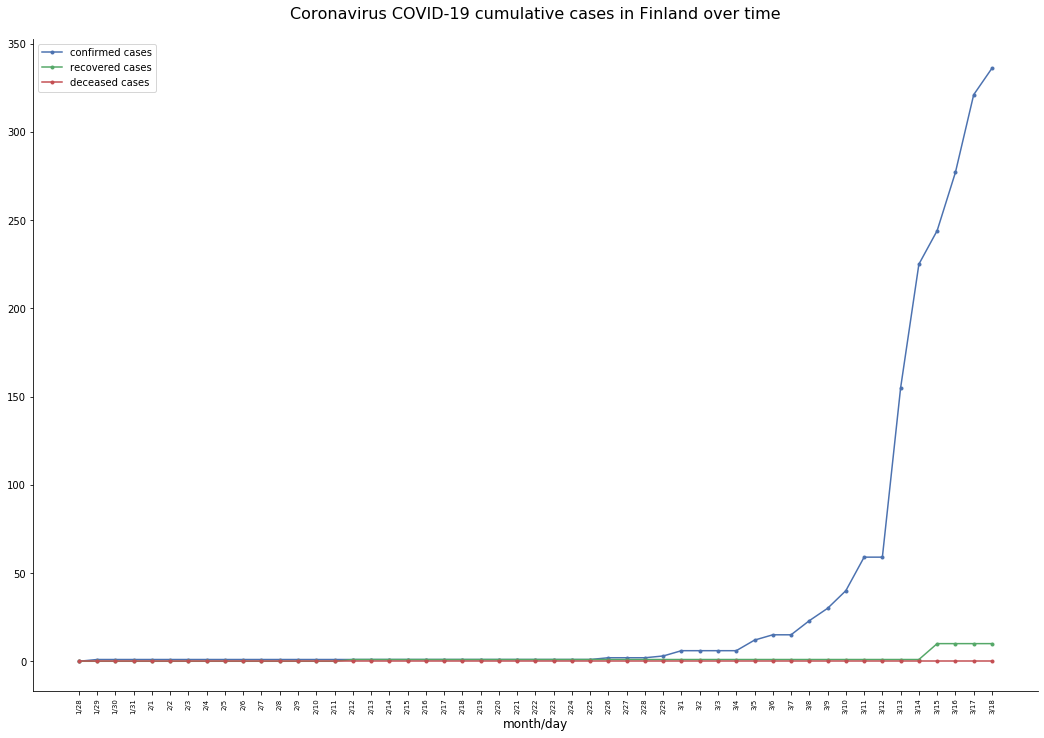

In [34]:
# Plotting daily cumulative cases in Finland
cust_line_plot((days_fin, finland_conf_6, ".", 0, "confirmed cases"),
               (days_fin, finland_recov_6, ".", 2, "recovered cases"),
               (days_fin, finland_deceas_6, ".", 3, "deceased cases"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative cases in Finland over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

**Description of the plot**

The blue curve represents the cumulative confirmed cases. Government decisions and people behavior can affect the way the blue curve looks like. The aim is to keep the curve not too steep in order not to saturate the capacity of the hospitals in the Country. However, it should be noted that the effects are not immediate due to the incubation period.

The green curve represents the recovered cases. The goal is trying to match the blue curve as close as possible, at a certain point in time.

The red curve represents the deceased cases and the goal is obviously to keep it as low as possible.

Finally, it shall not be forgotten that the number of actual cases might be higher than the number of confirmed cases.

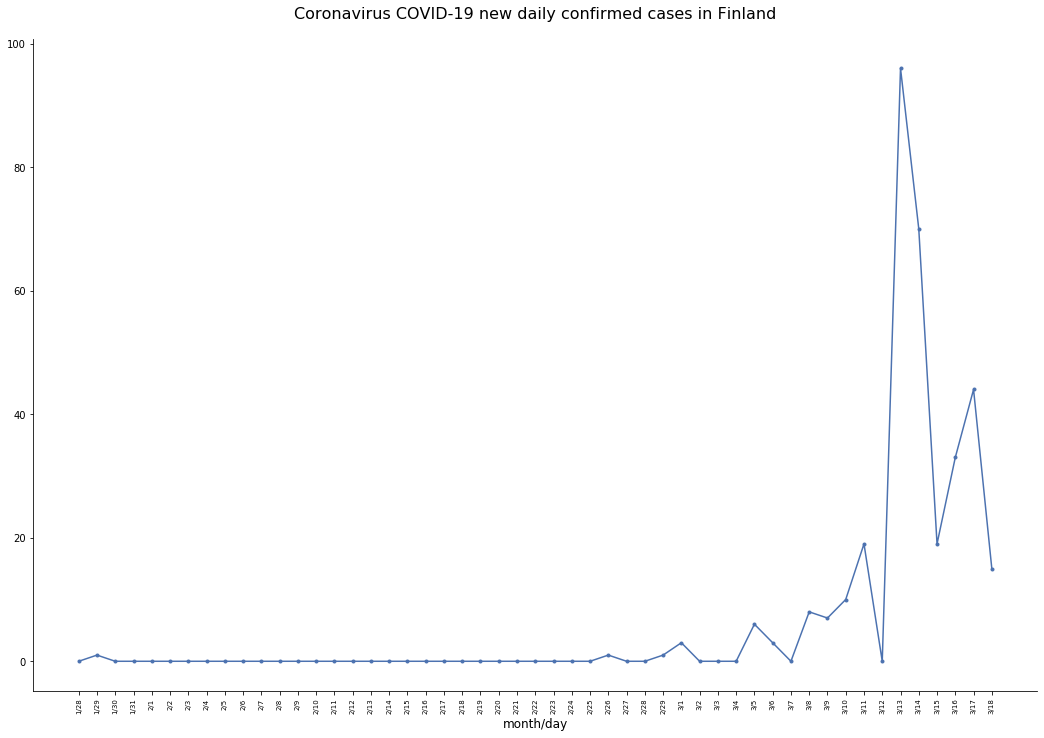

In [35]:
# Plotting new daily confirmed Coronavirus cases in Finland
cust_line_plot((days_fin, finland_conf_incr_6, ".", 0, ""),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 new daily confirmed cases in Finland",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=False)

**Description of the plot**

This plot shows the new daily confirmed cases. Therefore, it shows the speed at which the virus is spreading.

### 6.2. Comparison with Other Scandinavian Countries <a name="6.2."></a>

**Description of the plots**

Even by shifting all the curves so that they start for each Country in the day of the first confirmed case, it appears that the curve is not steeper than the other 3 curves. This means the virus is not spreading faster.

Even though the virus started later in Finland, the first recovered case happened much earlier than the other Scandinavian Countries.

Currently, Finland is also the only one among those Countries with no deceased cases.

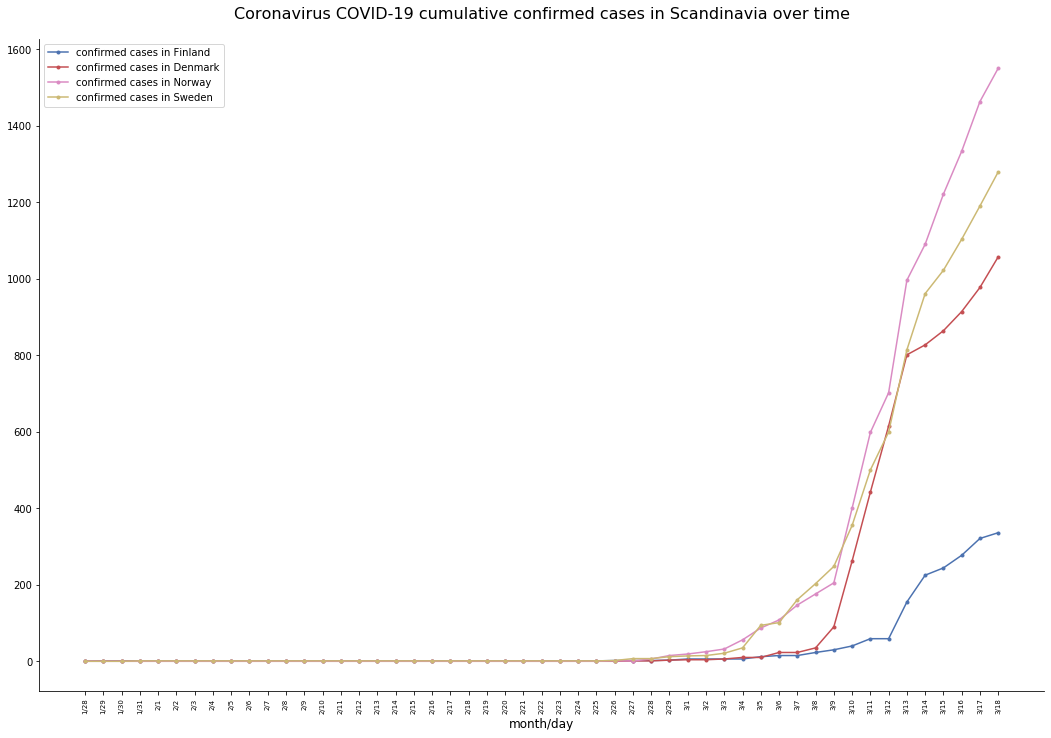

In [36]:
# Comparing cumulative confirmed cases over time in Scandinavia
cust_line_plot((days_fin, finland_conf_6, ".", 0, "confirmed cases in Finland"),
               (days_fin, denmark_conf_6, ".", 3, "confirmed cases in Denmark"),
               (days_fin, norway_conf_6, ".", 6, "confirmed cases in Norway"),
               (days_fin, sweden_conf_6, ".", 8, "confirmed cases in Sweden"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases in Scandinavia over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

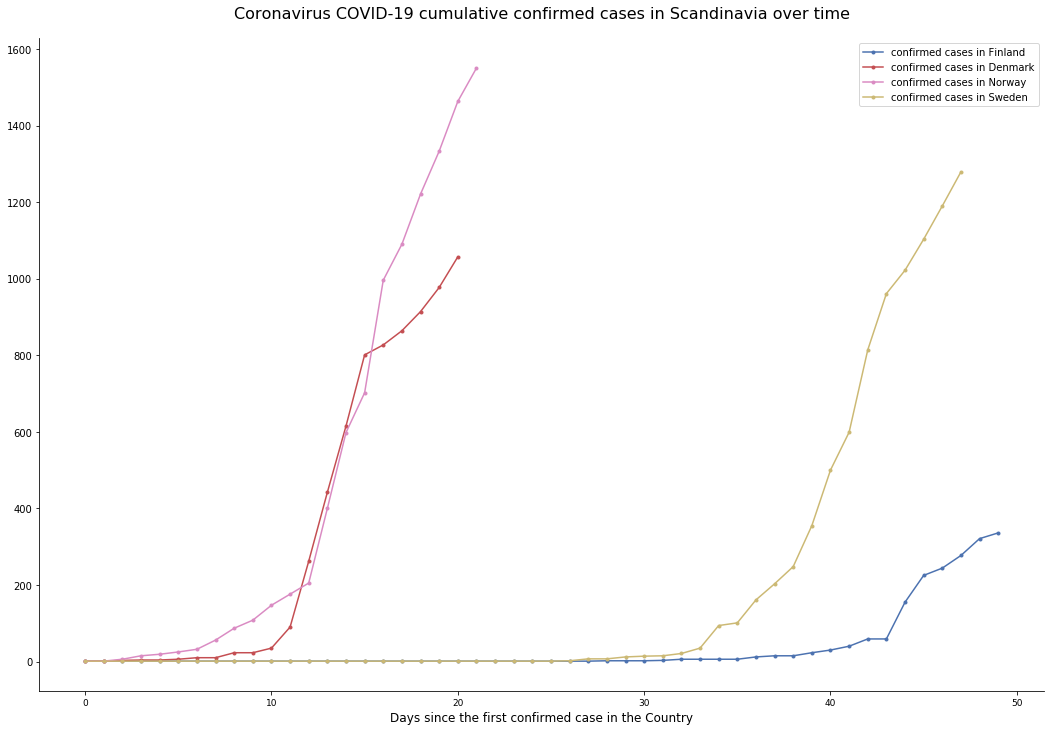

In [37]:
# Comparing cumulative confirmed cases over time in Scandinavia
# starting form the day of the first confirmed case
cust_line_plot((list(range(len(finland_conf_pos))), finland_conf_pos, ".", 0, "confirmed cases in Finland"),
               (list(range(len(denmark_conf_pos))), denmark_conf_pos, ".", 3, "confirmed cases in Denmark"),
               (list(range(len(norway_conf_pos))), norway_conf_pos, ".", 6, "confirmed cases in Norway"),
               (list(range(len(sweden_conf_pos))), sweden_conf_pos, ".", 8, "confirmed cases in Sweden"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases in Scandinavia over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="Days since the first confirmed case in the Country", xlabel_fs=12,
               xvalues_fs=9,rot=0,
               y_label=None, ylabel_fs=12,
               legend=True)

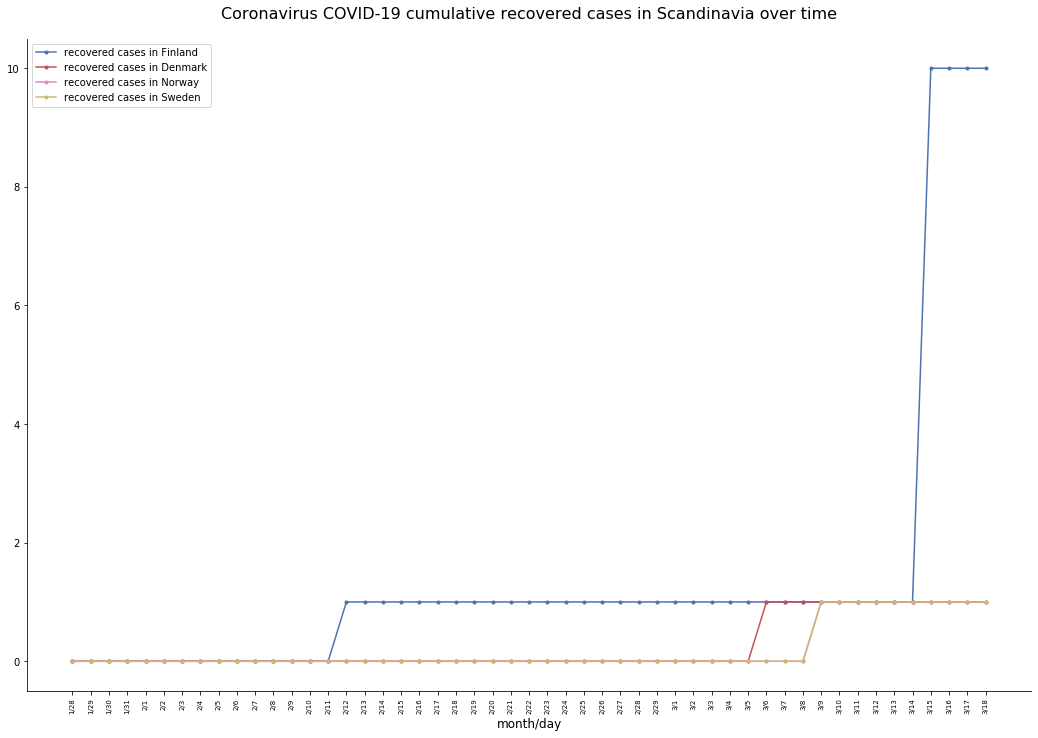

In [38]:
# Comparing cumulative recovered cases over time in Scandinavia
cust_line_plot((days_fin, finland_recov_6, ".", 0, "recovered cases in Finland"),
               (days_fin, denmark_recov_6, ".", 3, "recovered cases in Denmark"),
               (days_fin, norway_recov_6, ".", 6, "recovered cases in Norway"),
               (days_fin, sweden_recov_6, ".", 8, "recovered cases in Sweden"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative recovered cases in Scandinavia over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

NOTE: You do not see the curce for Norway since it is the same as the curve for Sweden.

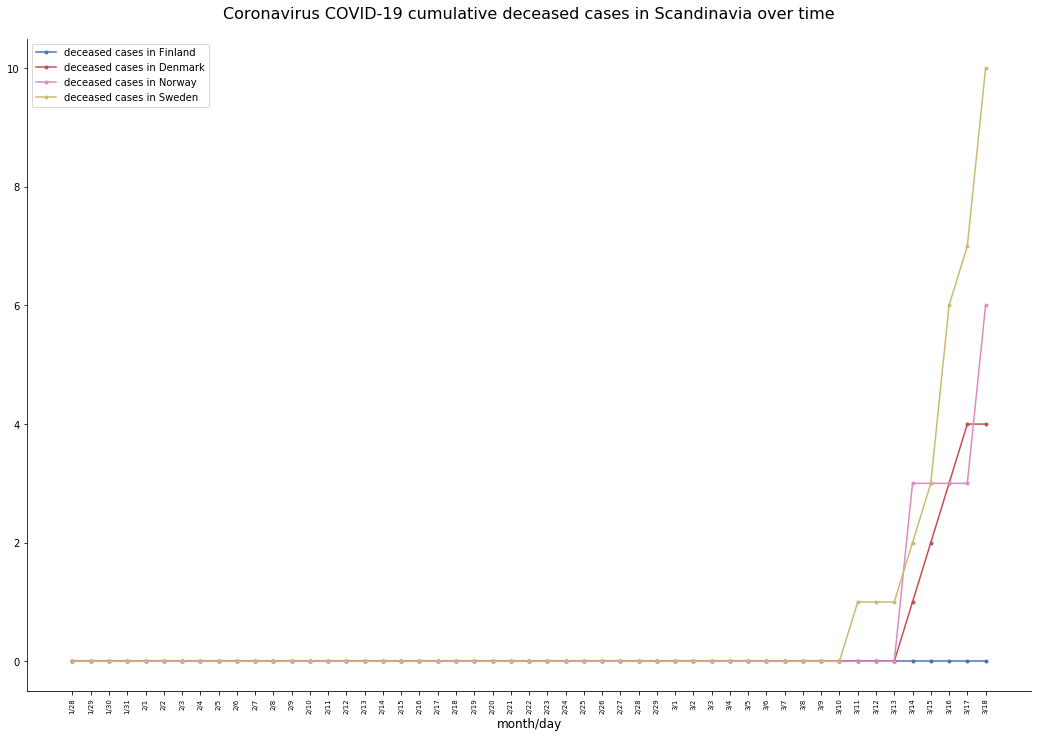

In [39]:
# Comparing cumulative deceased cases over time in Scandinavia
cust_line_plot((days_fin, finland_deceas_6, ".", 0, "deceased cases in Finland"),
               (days_fin, denmark_deceas_6, ".", 3, "deceased cases in Denmark"),
               (days_fin, norway_deceas_6, ".", 6, "deceased cases in Norway"),
               (days_fin, sweden_deceas_6, ".", 8, "deceased cases in Sweden"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative deceased cases in Scandinavia over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

### 6.3. Comparison with Italy and China<a name="6.3."></a>

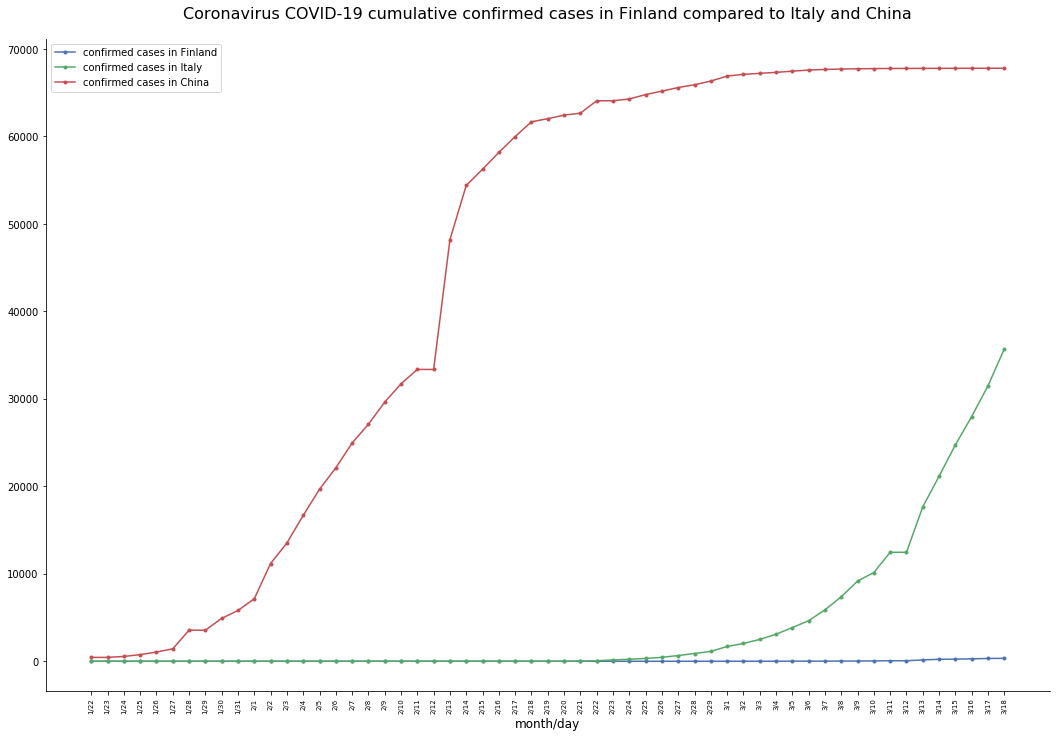

In [40]:
# Comparing cumulative confirmed cases over time for Finland, Italy and China
cust_line_plot((days_tot, finland_conf_0, ".", 0, "confirmed cases in Finland"),
               (days_tot, italy_conf_0, ".", 2, "confirmed cases in Italy"),
               (days_tot, china_conf_0, ".", 3, "confirmed cases in China"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases in Finland compared to Italy and China",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

### 6.4. World View<a name="6.4."></a>

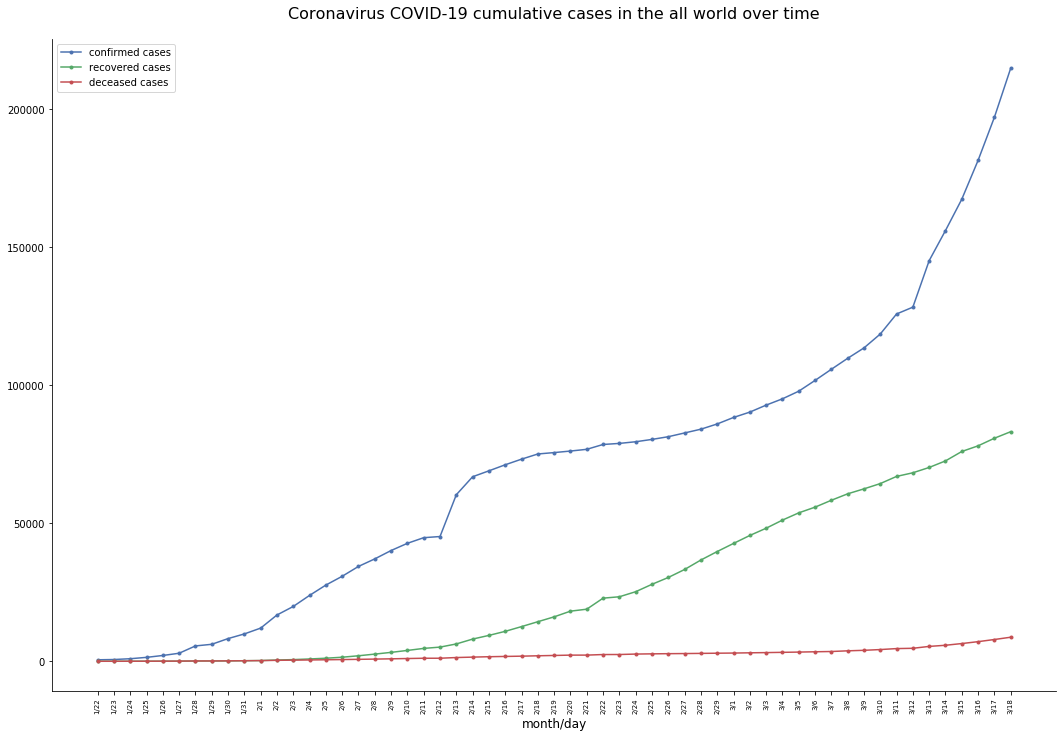

In [41]:
# Plotting daily cumulative cases in the all world
cust_line_plot((days_tot, world_conf_tot, ".", 0, "confirmed cases"),
               (days_tot, world_recov_tot, ".", 2, "recovered cases"),
               (days_tot, world_deceas_tot, ".", 3, "deceased cases"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative cases in the all world over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

## 7. Statistics <a name="7."></a>

### 7.1. World View <a name="7.1."></a>

In [42]:
# Reordering the columns
daily_rep_group = daily_rep_group.reindex(columns=['Confirmed', 'Recovered', 'Deaths'])

In [43]:
# The top 10 Countries by number of confirmed cases in descending order
print("Countries by number of confirmed cases in descending order (top 10) worldwide:")
daily_rep_group.sort_values(by ='Confirmed', ascending = False).head(10)

Countries by number of confirmed cases in descending order (top 10) worldwide:


,Confirmed,Recovered,Deaths
Country/Region,,,
China,81102,69755,3241
Italy,35713,4025,2978
Iran,17361,5389,1135
Spain,13910,1081,623
Germany,12327,105,28
France,9052,12,148
"Korea, South",8413,1540,84
US,7786,106,118
Switzerland,3028,15,28


In [44]:
# The top 10 Countries by number of recovered cases in descending order
print("Countries by number of recovered cases in descending order (top 10) worldwide:")
daily_rep_group.sort_values(by ='Recovered', ascending = False).head(10)

Countries by number of recovered cases in descending order (top 10) worldwide:


,Confirmed,Recovered,Deaths
Country/Region,,,
China,81102,69755,3241
Iran,17361,5389,1135
Italy,35713,4025,2978
"Korea, South",8413,1540,84
Spain,13910,1081,623
Cruise Ship,712,325,7
Japan,889,144,29
Singapore,313,114,0
US,7786,106,118


In [45]:
# The top 10 Countries by number of deceased cases in descending order
print("Countries by number of deceased cases in descending order (top 10) worldwide:")
daily_rep_group.sort_values(by ='Deaths', ascending = False).head(10)

Countries by number of deceased cases in descending order (top 10) worldwide:


,Confirmed,Recovered,Deaths
Country/Region,,,
China,81102,69755,3241
Italy,35713,4025,2978
Iran,17361,5389,1135
Spain,13910,1081,623
France,9052,12,148
US,7786,106,118
"Korea, South",8413,1540,84
United Kingdom,2642,67,72
Netherlands,2056,2,58


### 7.2. Finland <a name="7.2."></a>

In [46]:
# Visualizing the current status in Finland
print("Latest situation in Finland:\n")
print(daily_rep_group.loc['Finland'].to_string())

Latest situation in Finland:

Confirmed    336
Recovered     10
Deaths         0


## 8. Conclusions <a name="8."></a>

The plots are shortly described in section 6.

Due to the need of daily updates, no additional comment is added here.

---

In [47]:
print("Last plotted day:", dt.datetime.strptime(last_day, "%m-%d-%Y").date().strftime("%d-%b-%Y"))

Last plotted day: 18-Mar-2020


---
<sub>Used software:</sub><br>
<sub>- Jupyter Notebook server 6.0.1</sub><br>
<sub>- Python 3.6.8</sub><br>
<sub>- numpy 1.17.3</sub><br>
<sub>- pandas 0.25.2</sub><br>
<sub>- matplotlib 3.1.2</sub><br>
<sub>- seaborn 0.9.0</sub><br>
<sub>- regex 2019.8.19</sub><br>
<sub>on top of Linux Ubuntu 18.04</sub><br>